In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from eeprivacy.mechanisms import LaplaceMechanism
from eeprivacy.operations import PrivateAboveThreshold

np.random.seed(1234)  # Fix seed for deterministic documentation

mpl.style.use("seaborn-white")

MD = 28
LG = 36
plt.rcParams.update(
    {
        "figure.figsize": [25, 7],
        "legend.fontsize": MD,
        "axes.labelsize": LG,
        "axes.titlesize": LG,
        "xtick.labelsize": LG,
        "ytick.labelsize": LG,
    }
)

# Computing Clamped Mean Bounds with the Sparse Vector Technique #

In [Computing Bounds for Clamped Means](clamped-mean-bounds.ipynb), we determined the clamping parameters for a dataset of unknown range by issuing a `PrivateQuantile` query against a dataset. While simple, this approach depends on the assumption that clamping to the 99th percentile of a dataset will result in negligble error in downstream analytics. Sometimes it is desirable to determine clamping bounds with an error expression that is closer to the eventual use case.

This notebook demonstrates how a clamping bound can be chosen with an error expression based on the result of a query of a population, choosing a clamping bound that results in population-level error less than a small threshold. We use a sum query for demonstration, but it could easily be a more complex calculation, like the average load shape.

The approach employed here is adapted from [Applying the Sparse Vector Technique](https://uvm-plaid.github.io/programming-dp/notebooks/ch10.html#applying-the-sparse-vector-technique) in _Programming Differential Privacy_ [Near, 2020].


# Sparse Vector Technique for Clamping Bounds #

With SVT, we will issue a series of queries with different choices of clamping bounds, seeking a bound that provides acceptable accuracy against a queries similar to those that will be issued later.

We will issue a sequence of clamped sum queries against the entire pool of meters, looking for the first result that returns error less than a threshold. The threshold will be error less than 0.01 kWh average across 24 hours (or 0.24 kWh total across 24 hours).

**How do you choose epsilon for the SVT query?**

For SVT to return accurate results, the difference between "good" responses and "bad" response should be "large". This is what the "Sparse" in "Sparse Vector Technique" refers to. For our use case, we use a synthetic population to dial in the SVT privacy parameter.

Residential energy consumption values are closely approximated by a log-normal distribution. With `b` values (the clamping bound) spaced widely enough apart, each step will decrease error by an order of magnitude.

ε should be chosen to distinguish the correct clamping bound in almost every cases (say, 999/1000). 

A demonstration with a synthetic population of 5,000 meters is shown below, resulting in a required ε of 0.2

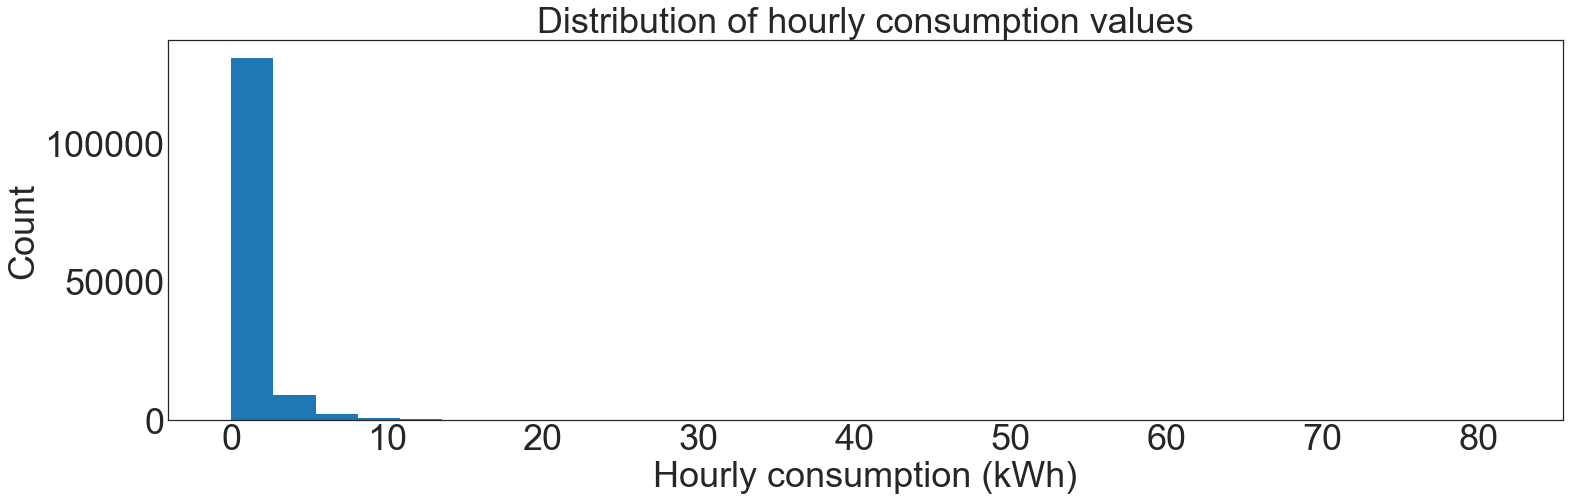

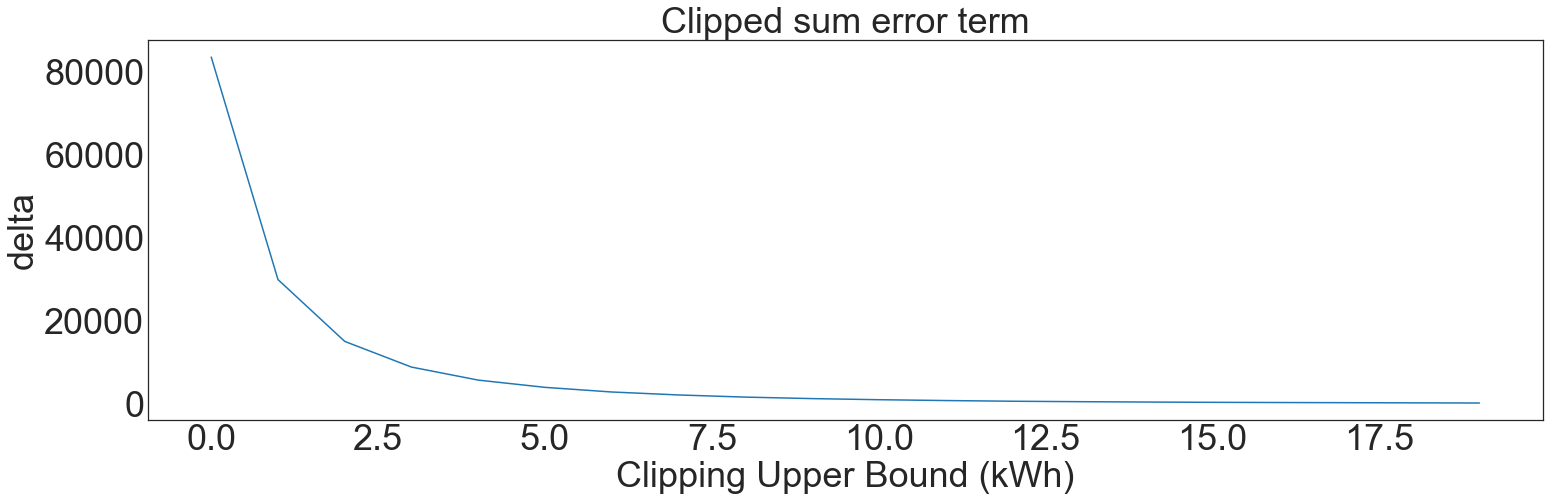

In [14]:
N = 6000
synthetic = np.random.lognormal(mean=-0.6, sigma=1.2, size=N * 24)
plt.hist(synthetic, bins=30)
plt.title("Distribution of hourly consumption values")
plt.xlabel("Hourly consumption (kWh)")
plt.ylabel("Count")
plt.show()

clipped_sums = []
bs = np.linspace(start=1, stop=20, num=20)
for b in bs:
    clipped_sums.append(
        np.sum(np.clip(synthetic, 0, b)) - np.sum(np.clip(synthetic, 0, b - 1))
    )

plt.plot(clipped_sums)
plt.title("Clipped sum error term")
plt.xlabel("Clipping Upper Bound (kWh)")
plt.ylabel("delta")
plt.show()

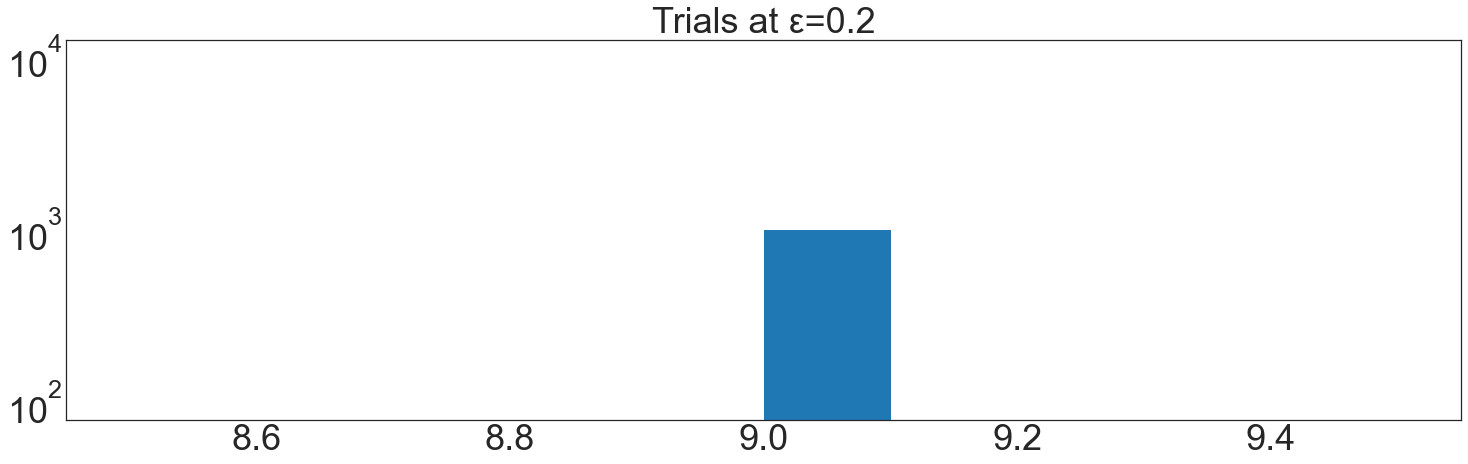

In [15]:
trials = []

qs = -np.array(clipped_sums)

threshold = 0.01 * N * 24

epsilon = 0.2

above_threshold = PrivateAboveThreshold()

for t in range(1000):
    trials.append(
        above_threshold.execute(queries=qs, threshold=-threshold, epsilon=epsilon)
    )

plt.hist(trials)
plt.yscale("log")
plt.title(f"Trials at ε={epsilon}")
plt.show()